<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Reformat" data-toc-modified-id="Reformat-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Reformat</a></span><ul class="toc-item"><li><span><a href="#NoData-mask" data-toc-modified-id="NoData-mask-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>NoData mask</a></span></li><li><span><a href="#Pixel-index" data-toc-modified-id="Pixel-index-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Pixel index</a></span></li><li><span><a href="#Solar-Zenith-Angles" data-toc-modified-id="Solar-Zenith-Angles-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Solar Zenith Angles</a></span></li></ul></li><li><span><a href="#Albedo" data-toc-modified-id="Albedo-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Albedo</a></span></li><li><span><a href="#Write-text-outputs" data-toc-modified-id="Write-text-outputs-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Write text outputs</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#THIS-LOOP-IS-TOO-SLOW" data-toc-modified-id="THIS-LOOP-IS-TOO-SLOW-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>THIS LOOP IS TOO SLOW</a></span></li></ul></li></ul></li><li><span><a href="#Plots" data-toc-modified-id="Plots-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plots</a></span></li><li><span><a href="#Bonus" data-toc-modified-id="Bonus-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Bonus</a></span><ul class="toc-item"><li><span><a href="#Linear-regression" data-toc-modified-id="Linear-regression-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Linear regression</a></span></li></ul></li><li><span><a href="#Seasons" data-toc-modified-id="Seasons-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Seasons</a></span><ul class="toc-item"><li><span><a href="#seasons" data-toc-modified-id="seasons-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>seasons</a></span></li></ul></li></ul></div>

# Results
## Reformat 
*... our results netCDF(s) to match the input text file structure required by the Florida USGS evapotranspiration model.*

Glob for the result dataset(s) and print the header for one of them:

In [1]:
import glob
import matplotlib.pyplot as plt

import warnings; warnings.filterwarnings('ignore')
sort2 = lambda ls: sorted(ls, key=lambda x: int(x.split("_")[-1][:-3]))

bsa_result = sort2(glob.glob("result/black_albedo*.nc"))
wsa_result = sort2(glob.glob("result/white_albedo*.nc"))
alb_result = sort2(glob.glob("result/blue_albedo*.nc"))

print("Black sky albedo outputs for 2018:"); bsa_result

Black sky albedo outputs for 2018:


['result/black_albedo_MCD43A1.2018_1.nc',
 'result/black_albedo_MCD43A1.2018_2.nc',
 'result/black_albedo_MCD43A1.2018_3.nc',
 'result/black_albedo_MCD43A1.2018_4.nc',
 'result/black_albedo_MCD43A1.2018_5.nc',
 'result/black_albedo_MCD43A1.2018_6.nc',
 'result/black_albedo_MCD43A1.2018_7.nc',
 'result/black_albedo_MCD43A1.2018_8.nc',
 'result/black_albedo_MCD43A1.2018_9.nc',
 'result/black_albedo_MCD43A1.2018_10.nc',
 'result/black_albedo_MCD43A1.2018_11.nc',
 'result/black_albedo_MCD43A1.2018_12.nc']

Read the twelve black sky albedo netCDFs as a multidataset and print the header:

In [2]:
import xarray as xr
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)

ds = xr.open_mfdataset(bsa_result)

### NoData mask
Make an array of booleans that represent masked pixels by reading the first timestep of the input dataset and checking for `np.nan`:

In [3]:
# temporarily open the input dataset that we processed previously
with xr.open_dataset("data/MCD43A1.2018.nc") as tmp:
    
    # select timestep 1 of band 1 of the input dataset
    tmp_array = tmp["BRDF_Albedo_Parameters_Band1"][0].sel(Num_Parameters=0)
    
    # get the inverse of the boolean array of invalid pixels
    mask_array = np.logical_not(np.isnan(tmp_array.data))

mask_array

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

Make an `xarray.DataArray` for the mask and add it to the results dataset:

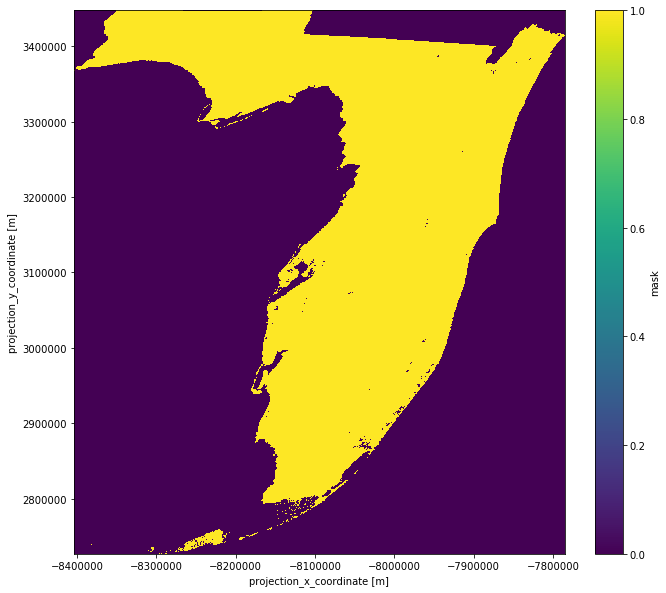

In [4]:
%matplotlib inline

ds.coords["mask"] = xr.DataArray(
    data=mask_array,
    coords=[ds.y, ds.x],
    dims=["y", "x"],
    attrs=dict(
        grid_mapping="crs", 
        flag_values="0 1", 
        flag_meanings="nodata data"))

ds.coords["mask"].plot(x="x", y="y", figsize=(11,10))

### Pixel index

Make an array of index values for the permuted xy arrays. The evapotranspiration model takes inputs that sequence in column-major order:
```
 1  24.249  -79.398  0.000 0.000 0.000 ... 
 2  24.266  -79.398  0.000 0.000 0.000 ...
 3  24.284  -79.398  0.000 0.000 0.000 ...
 4  24.302  -79.398  0.000 0.000 0.000 ...  
```

So, reshape the index array using the shape of longitude array in the results dataset:

In [5]:
xyindex = np.array(list(range(ds.x.size*ds.y.size)))    # seq 1 to npixels
xyindex = xyindex.reshape(ds.lon.shape)                 # reshape with lon

xyindex

array([[      0,       1,       2, ...,    1333,    1334,    1335],
       [   1336,    1337,    1338, ...,    2669,    2670,    2671],
       [   2672,    2673,    2674, ...,    4005,    4006,    4007],
       ...,
       [2073472, 2073473, 2073474, ..., 2074805, 2074806, 2074807],
       [2074808, 2074809, 2074810, ..., 2076141, 2076142, 2076143],
       [2076144, 2076145, 2076146, ..., 2077477, 2077478, 2077479]])

Add `xyindex` array to the dataset as a coordinate variable:

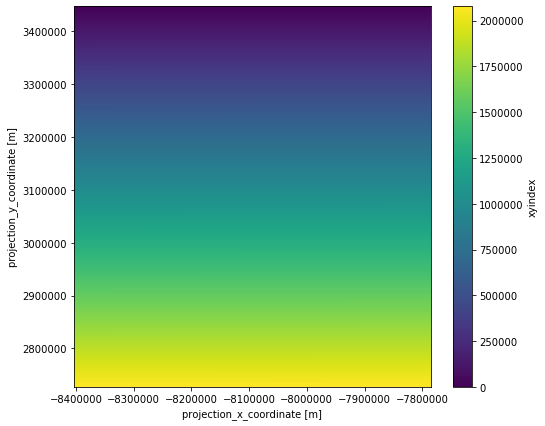

In [6]:
ds.coords["xyindex"] = xr.DataArray(
    data=xyindex,
    coords=[ds.y, ds.x],
    dims=["y", "x"])

ds["xyindex"].plot(x="x", y="y", figsize=(8,7))

### Solar Zenith Angles

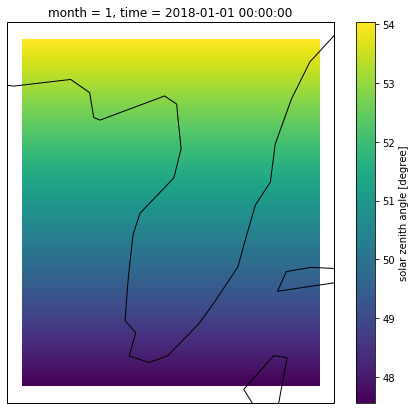

In [7]:
import cartopy.crs as ccrs

sinu = ccrs.Sinusoidal(
    central_longitude=ds.crs.longitude_of_central_meridian, 
    false_northing=ds.crs.false_northing, 
    false_easting=ds.crs.false_northing, 
    globe=None)

fig = plt.figure(figsize=(8,7))
ax = plt.axes(projection=sinu)
ds["solar_zenith_angle"][0].plot(ax=ax)
ax.coastlines()

## Albedo

In [22]:
t = ds["BRDF_Albedo_Parameters_Band1"].groupby("time.month").mean("time")
t

<xarray.DataArray 'BRDF_Albedo_Parameters_Band1' (month: 12, y: 1555, x: 1336)>
dask.array<shape=(12, 1555, 1336), dtype=float64, chunksize=(1, 1555, 1336)>
Coordinates:
    lat      (y, x) float64 31.0 31.0 31.0 31.0 31.0 ... 24.53 24.53 24.53 24.53
    lon      (y, x) float64 -88.17 -88.17 -88.16 -88.16 ... -76.97 -76.96 -76.96
  * x        (x) float64 -8.404e+06 -8.403e+06 ... -7.786e+06 -7.785e+06
  * y        (y) float64 3.447e+06 3.447e+06 3.446e+06 ... 2.728e+06 2.727e+06
    mask     (y, x) bool False False False False ... False False False False
    xyindex  (y, x) int64 0 1 2 3 4 ... 2077475 2077476 2077477 2077478 2077479
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

## Write text outputs
Now write each valid pixel's time series to an output text file. This could take a while so make a simple progress bar widget to monitor progress:

In [ ]:
import time, sys
from IPython.display import clear_output

def update_progress(progress, nbar=20):
    """Simple ASCII progress bar for Jupyter environment."""
    
    if isinstance(progress, int): 
        progress = float(progress)
    if not isinstance(progress, float): 
        progress = 0
    if progress < 0: 
        progress = 0
    if progress >= 1: 
        progress = 1
    block = int(round(nbar*progress))
    
    clear_output(wait = True)
    prog = "Progress: [{0}] {1:.1f}%"
    print(prog.format("#"*block+"-"*(nbar-block), progress*100))

#### THIS LOOP IS TOO SLOW

Loop over pixels and write valid data to text file:

In [ ]:
npixel = 0

tmpds = ds["BRDF_Albedo_Parameters_Band1"]

# open output table for writing
with open("result/band1_black_2018.dat", "w") as f:
    
    # iterate over rows
    for i in range(0, tmpds.y.size):
        
        # iterate over columns
        for j in range(0, tmpds.x.size):
        
            # select pixel
            tmp = tmpds.isel(x=i, y=j)
            
            # if mask value == True (valid data)
            if tmp.coords["mask"]:
                
                # join row items with tabs and write
                f.write("\t".join([
                    str(npixel),
                    str(tmp.lat.data),
                    str(tmp.lon.data),
                    "\t".join([str(v) for v in tmp.data])]) + "\n")
            
            # update progress bar
            update_progress((i * tmpds.y.size + j) / tmpds.xyindex.size)

update_progress(1) # done